# ML for Time Series

## A Unified Framework for Structured Graph Learning via Spectral Constraints

Baptiste Collet - Cyril Miras

## Experiments

### Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.datasets as skd
import sklearn.metrics as skm
from learnGraphTopology import *

does it reload


## Popular synthetic datasets

In [4]:
def dist_mat_exp_kernel(x, sigma=1, eps=1, k=None):
    n, d = x.shape
    dist_mat = np.zeros((n, n))
    for i in range(n):
        dist_mat[i] = np.exp(-np.linalg.norm(x[i] - x, axis=1)/eps)
    if not k is None:
        for i in range(n):
            k_th_nearest_dist = np.sort(dist_mat[i])[-k]
            dist_mat[i][dist_mat[i] < k_th_nearest_dist] = 0
        dist_mat = 0.5*(dist_mat + dist_mat.T)
    else:
        dist_mat[dist_mat<eps] = 0
    return dist_mat

We load the "two moons" dataset

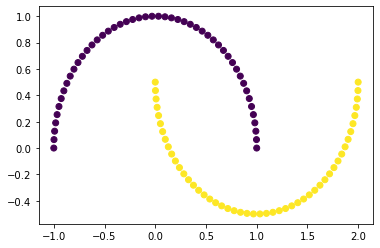

In [10]:
n_samples = 100
moons_data, moons_labels = skd.make_moons(n_samples=n_samples)
plt.scatter(moons_data.T[0], moons_data.T[1], c=moons_labels)
plt.show()

In [11]:
C_moons = dist_mat_exp_kernel(moons_data, sigma=1, eps=0.1)

In [12]:
res_moons = learn_k_component_graph(C_moons, k=2, maxiter=2000) #2000 or more in reality

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 801.66it/s]


In [14]:
score_moons = np.linalg.eigh(res_moons["Laplacian"])[1][:, 1]
print("AUC score of the spectral classifier", skm.roc_auc_score(moons_labels, score_moons))

AUC score of the spectral classifier 0.6248


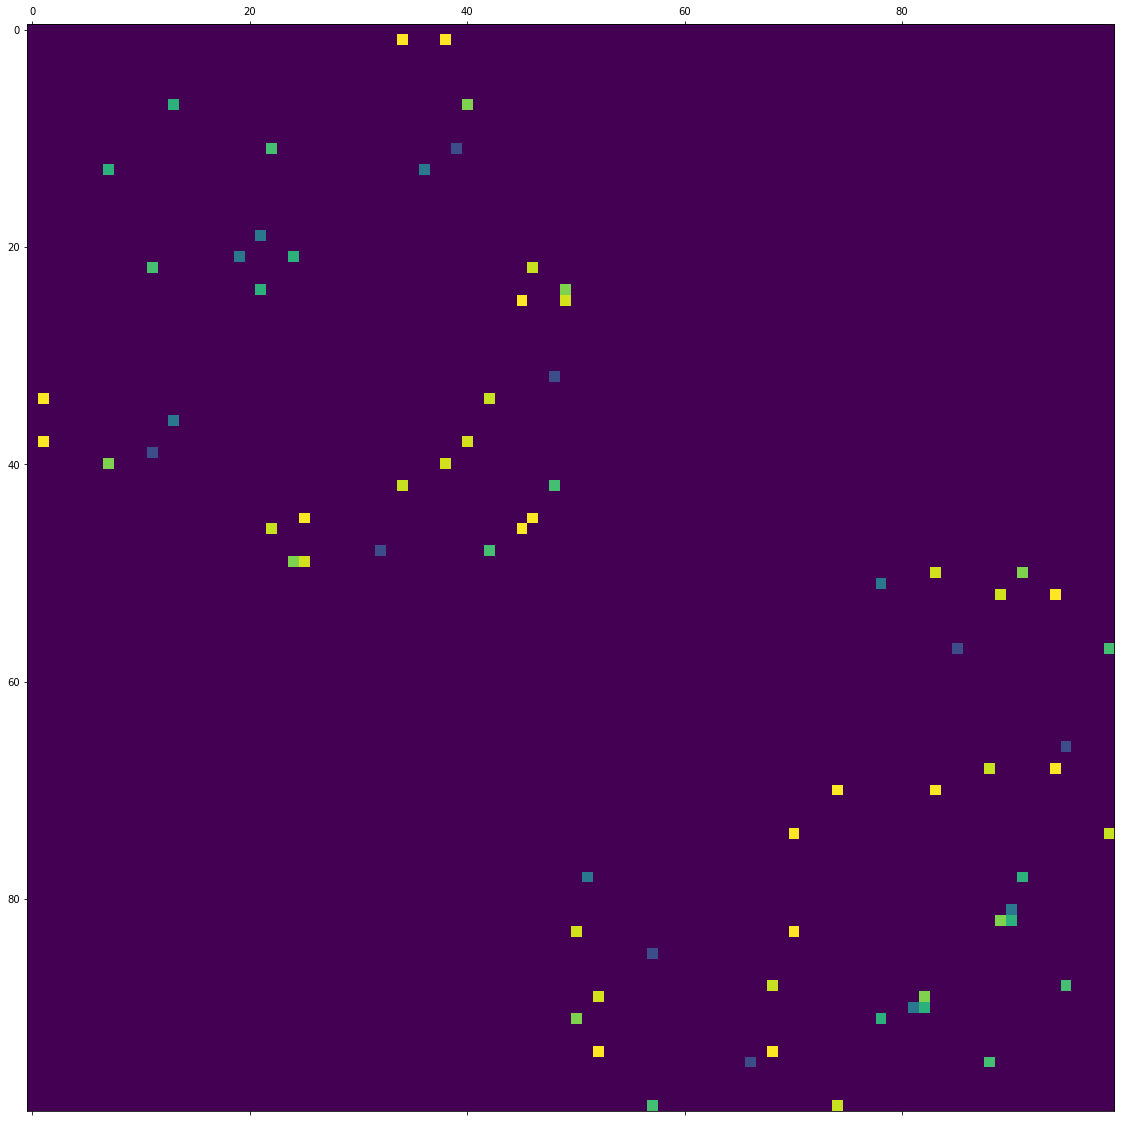

In [15]:
id_moons = np.argsort(moons_labels)
fig = plt.figure(figsize=(20, 20))
plt.matshow(res_moons["Adjacency"][id_moons][:, id_moons], fignum=0)
plt.show()

We load the "two circles" dataset

In [29]:
def at_least_k_component(L,k):
    la,M=np.linalg.eigh(L)
    la[:k] = 0
    return M@np.diag(la)@M.T

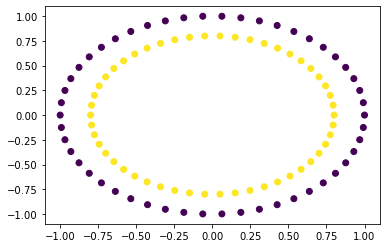

In [2]:
n_samples = 100
circles_data, circles_labels = skd.make_circles(n_samples=n_samples)
plt.scatter(circles_data.T[0], circles_data.T[1], c=circles_labels)
plt.show()

In [22]:
C_circles = dist_mat_exp_kernel(circles_data, k=7,sigma=0.1)
res_circles = learn_k_component_graph(C_circles, k=2, maxiter=10000,lb=10**-5) #2000 or more in reality

 53%|████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 5294/10000 [00:07<00:06, 754.98it/s]


In [23]:
print(res_circles["convergence"])

True


In [30]:
res_circles["Laplacian"]=at_least_k_component(res_circles["Laplacian"],k=2)

In [31]:
print(nb_connected_component(res_circles["Laplacian"]))

2


In [28]:
print(np.array([[0.3,0.02],[0.02,0.3]]).round(1))
np.linalg.eigh(res_circles["Laplacian"])[0][1]

[[0.3 0. ]
 [0.  0.3]]


0.014670559045444825

In [32]:
score_circles = np.linalg.eigh(res_circles["Laplacian"])[1][:, 1]
print("AUC score of the spectral classifier", skm.roc_auc_score(circles_labels, score_circles))

AUC score of the spectral classifier 0.5196


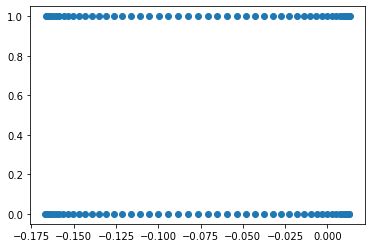

In [33]:
plt.scatter(score_circles, circles_labels)

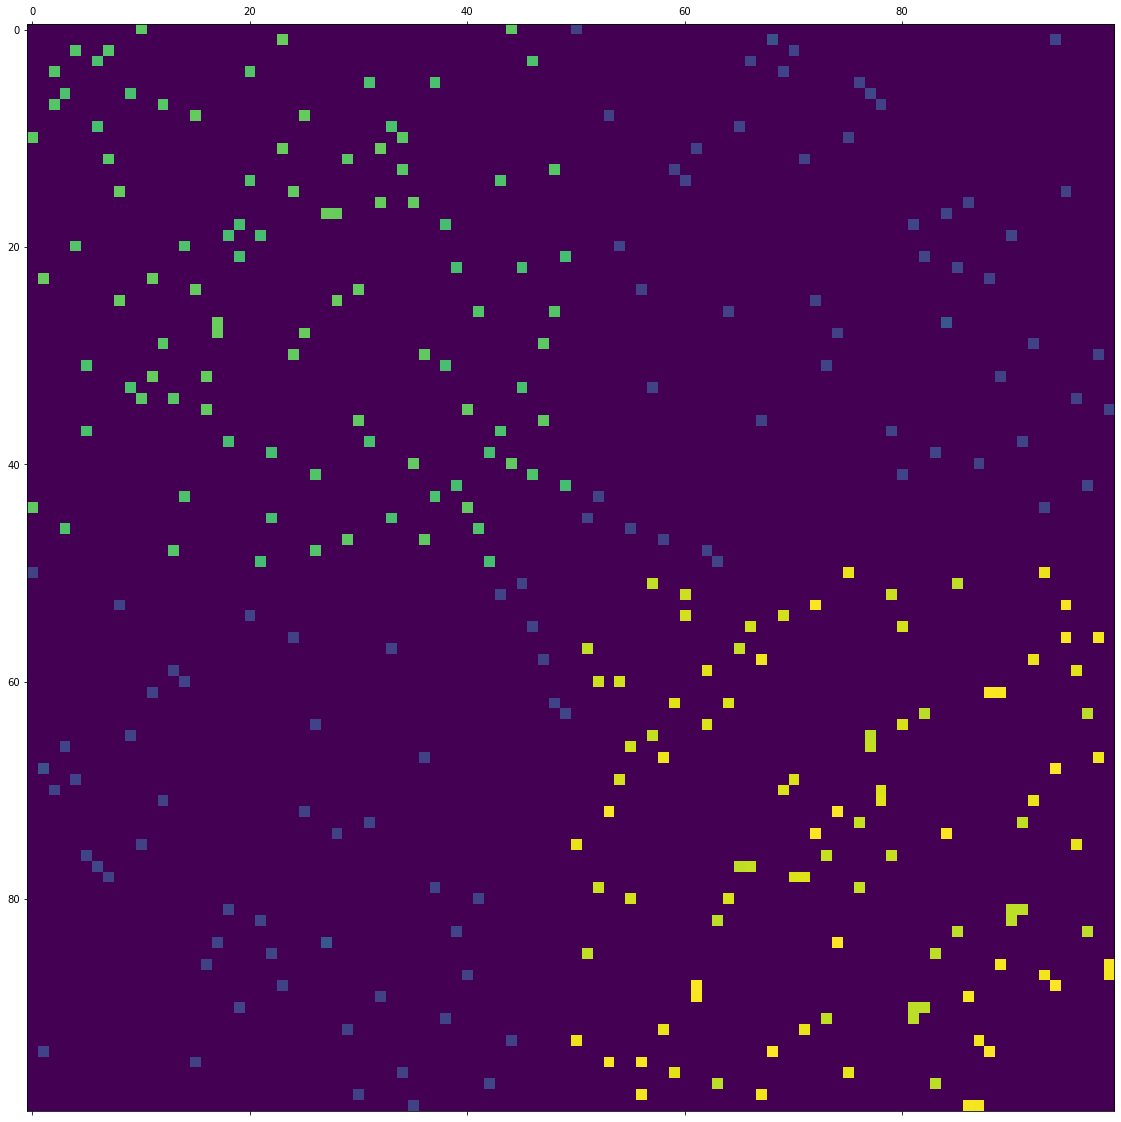

In [35]:
id_circles = np.argsort(circles_labels)
fig = plt.figure(figsize=(20, 20))
plt.matshow(res_circles["Adjacency"][id_circles][:, id_circles], fignum=0)
plt.show()

In [39]:
A=res_circles["Adjacency"][id_circles][:, id_circles]
print(np.max(A[60:,:40]),np.max(A[:40,60:]))
print(np.max(A))

1.2291195212897192 1.2291195212897192
4.529841298153861


## Gene dataset

This dataset come from https://archive.ics.uci.edu/ml/datasets/gene+expression+cancer+RNA-Seq#

It represents 801 patients with cancers of 5 different types

The features of the data are RNA-Seq gene expression levels

The label is the tumor type

To make the code work, download the dataset,extract it and save data and labels in the folder ./data/genes/

In [ ]:
gene_df = pd.read_csv("data/genes/data.csv")
gene_df = gene_df[gene_df.columns[1:]]
gene_df

In [ ]:
gene_labels = pd.read_csv("data/genes/labels.csv")
gene_labels = gene_labels[gene_labels.columns[1:]]
gene_labels

The goal is to model the distribution with a $k$ component graph, in order to clusetr the data into $k$ classes. As there are $k=5$ classes in reality, we try the algorithm with this value.

In [ ]:
C = np.cov(gene_df.values)

In [ ]:
res_genes = learn_k_component_graph(C, k=5, maxiter=20) #2000 or more in reality

Then, we reorganise the matrix according to their labels to see visually if the components that should be connected are effectively connected.

In [ ]:
id_genes = np.argsort(gene_labels.values.squeeze())

In [ ]:
fig = plt.figure(figsize=(20, 20))
plt.matshow(res_genes["Adjacency"][id_genes][:, id_genes], fignum=0)
plt.show()

In [ ]:
print(np.sort(np.linalg.eig(res_genes["Laplacian"])[0]))